In [1]:
import meshio
import numpy as np
from dolfinx import mesh, fem
from mpi4py import MPI
import basix
import pyvista as pv

from dolfinx.io import XDMFFile

[Rohans-MacBook-Pro.local:29791] shmem: mmap: an error occurred while determining whether or not /var/folders/hj/g_ncdftd5lncyq_628n7jckw0000gn/T//ompi.Rohans-MacBook-Pro.501/jf.0/2711617536/sm_segment.Rohans-MacBook-Pro.501.a1a00000.0 could be created.


pitch: [0.1 0.1 0.1] <class 'trimesh.caching.TrackedArray'>


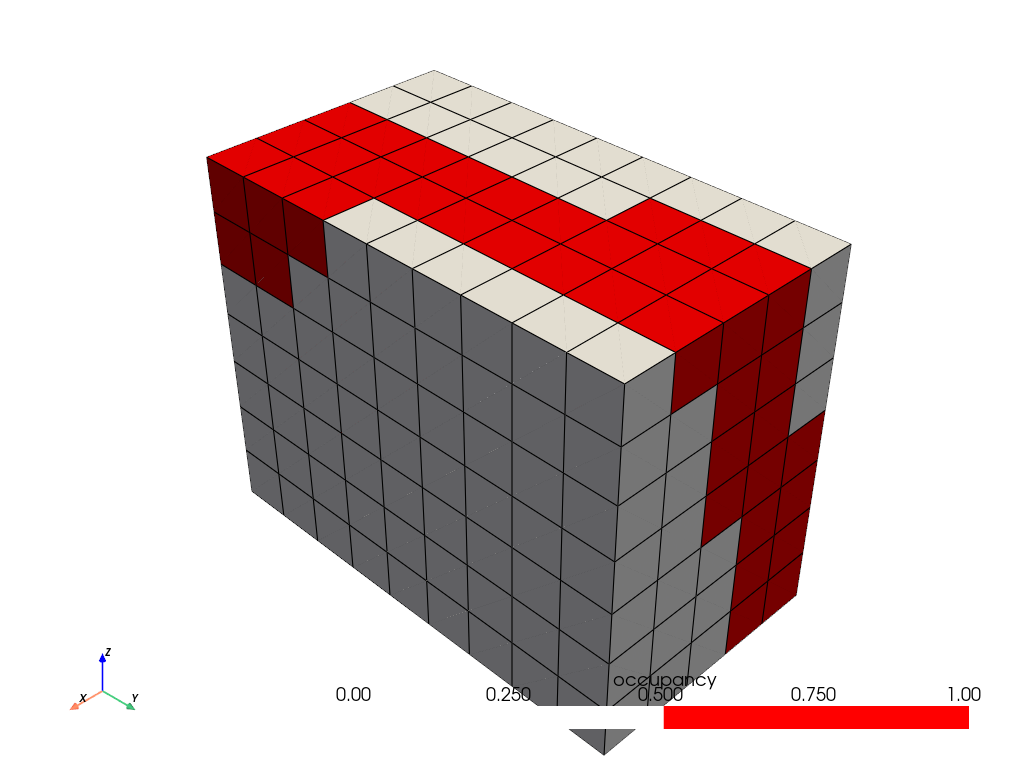

In [2]:
import numpy as np
import pyvista as pv
import trimesh

mesh = trimesh.load('test.stl')
voxel_size = 0.1
voxel_grid = mesh.voxelized(pitch=voxel_size)

occupancy = voxel_grid.matrix
origin = voxel_grid.bounds[0]

# Check the nature of voxel_grid.pitch
pitch_val = voxel_grid.pitch
print("pitch:", pitch_val, type(pitch_val))

# If it's a single float or single-element array:
if isinstance(pitch_val, np.ndarray):
    if pitch_val.size == 1:
        pitch = float(pitch_val.item())
        grid_spacing = (pitch, pitch, pitch)
    else:
        # Multiple values, assume this is a 3-element spacing
        grid_spacing = tuple(map(float, pitch_val))
else:
    # If it's already a float
    grid_spacing = (float(pitch_val), float(pitch_val), float(pitch_val))

X, Y, Z = occupancy.shape
grid = pv.ImageData()
grid.dimensions = (X+1, Y+1, Z+1)
grid.origin = origin
grid.spacing = grid_spacing

values = occupancy.astype(np.uint8).ravel(order='F')
grid.cell_data["occupancy"] = values

plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, scalars="occupancy", cmap=["white", "red"])
plotter.add_axes()
plotter.show()


Best rotation found with area: 0.5117337273598408


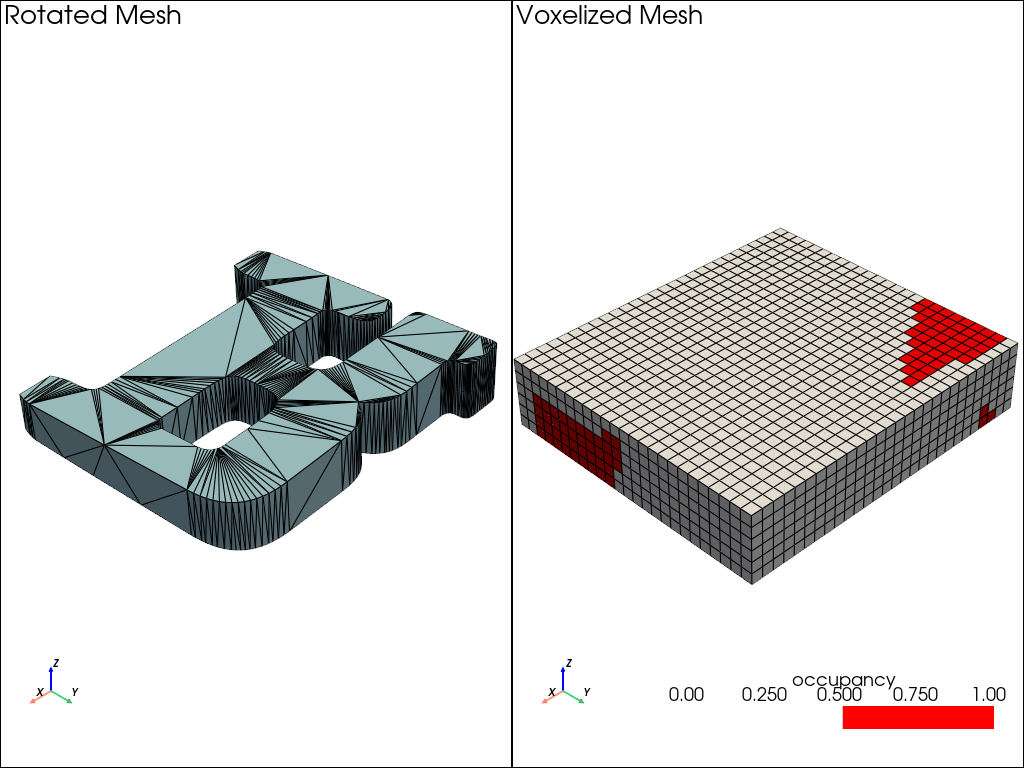

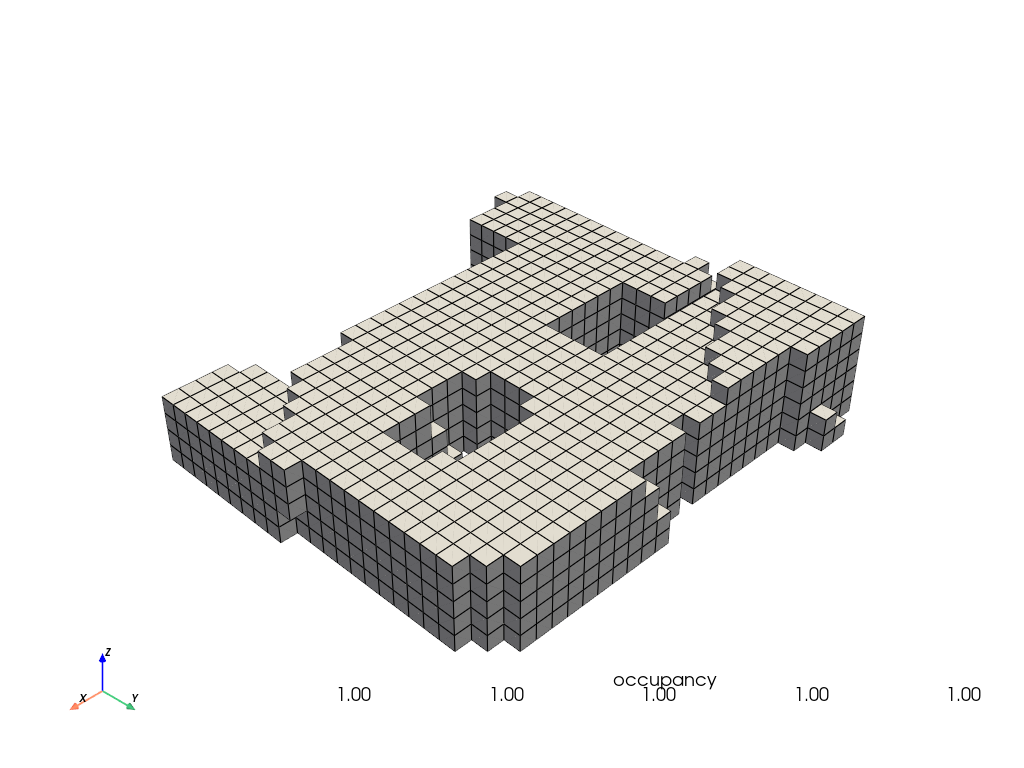

In [3]:
import trimesh
import numpy as np
import pyvista as pv
from scipy.spatial import ConvexHull

mesh = trimesh.load('test.stl')

# Compute stable poses
poses, probs = mesh.compute_stable_poses()

max_area = 0.0
best_pose = None

for transform in poses:
    # Apply pose to a copy of the mesh
    posed_mesh = mesh.copy()
    posed_mesh.apply_transform(transform)
    
    # Project vertices onto XY-plane
    points_2d = posed_mesh.vertices[:, :2]
    
    # Compute the 2D convex hull using SciPy
    hull = ConvexHull(points_2d)
    
    # In 2D, hull.volume corresponds to the polygon area of the hull
    area = hull.volume
    if area > max_area:
        max_area = area
        best_pose = transform

if best_pose is not None:
    print("Best rotation found with area:", max_area)
    # Apply this rotation permanently to the original mesh
    mesh.apply_transform(best_pose)

# Convert the rotated mesh to a PyVista mesh for display
# trimesh to pyvista conversion:
# - vertices: mesh.vertices (N x 3)
# - faces: mesh.faces is (M x 3)
#   Need to prepend each face with the number of vertices (3), resulting in (M x 4)
faces_pv = np.c_[np.full((mesh.faces.shape[0], 1), 3), mesh.faces]
pv_mesh = pv.PolyData(mesh.vertices, faces_pv)

# Now voxelize the tilted mesh
voxel_size = 0.03
voxel_grid = mesh.voxelized(pitch=voxel_size)

occupancy = voxel_grid.matrix
origin = voxel_grid.bounds[0]

pitch = voxel_grid.pitch
if isinstance(pitch, np.ndarray):
    if pitch.size == 1:
        pitch = float(pitch.item())
    else:
        pitch = float(pitch[0])

X, Y, Z = occupancy.shape

# Create a PyVista ImageData for voxel visualization
grid = pv.ImageData()
grid.dimensions = (X+1, Y+1, Z+1)
grid.origin = origin
grid.spacing = (pitch, pitch, pitch)

values = occupancy.astype(np.uint8).ravel(order='F')
grid.cell_data["occupancy"] = values

# Create a plotter with two subplots (1 row, 2 columns)
plotter = pv.Plotter(shape=(1, 2))

# Left subplot: Rotated mesh
plotter.subplot(0, 0)
plotter.add_mesh(pv_mesh, color="lightblue", show_edges=True)
plotter.add_axes()
plotter.add_text("Rotated Mesh", font_size=12)

# Right subplot: Voxelized Mesh
plotter.subplot(0, 1)
plotter.add_mesh(grid, show_edges=True, scalars="occupancy", cmap=["white", "red"])
plotter.add_axes()
plotter.add_text("Voxelized Mesh", font_size=12)

plotter.show()

# Threshold the grid so we only keep cells with occupancy > 0.5
occupied_only = grid.threshold(value=0.5, scalars="occupancy")

plotter = pv.Plotter()
plotter.add_mesh(occupied_only, show_edges=True, scalars="occupancy", cmap=["white", "red"])
plotter.add_axes()
plotter.show()



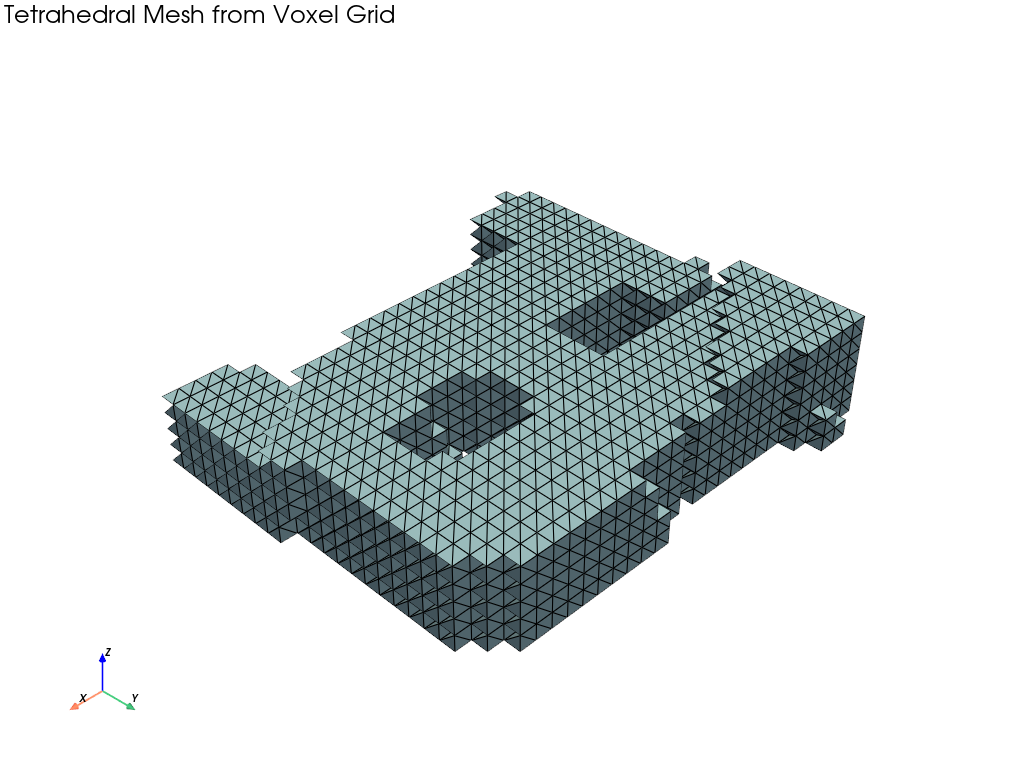

In [4]:
import trimesh

nx, ny, nz = X+1, Y+1, Z+1
points = np.zeros((nx*ny*nz, 3))
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            idx = i + nx*j + nx*ny*k
            points[idx] = [origin[0] + i*pitch,
                           origin[1] + j*pitch,
                           origin[2] + k*pitch]

# Each voxel is identified by (i, j, k) in [0..X-1, 0..Y-1, 0..Z-1]
# Let's tetrahedralize only occupied voxels
tets_stl = []
for k in range(Z):
    for j in range(Y):
        for i in range(X):
            if occupancy[i, j, k] == 1:
                # Corner point IDs of this voxel
                v0 = i     + nx*j       + nx*ny*k
                v1 = (i+1) + nx*j       + nx*ny*k
                v2 = (i+1) + nx*(j+1)   + nx*ny*k
                v3 = i     + nx*(j+1)   + nx*ny*k
                v4 = i     + nx*j       + nx*ny*(k+1)
                v5 = (i+1) + nx*j       + nx*ny*(k+1)
                v6 = (i+1) + nx*(j+1)   + nx*ny*(k+1)
                v7 = i     + nx*(j+1)   + nx*ny*(k+1)

                # Add the 5 tetrahedra from this voxel
                tets_stl.append([v0, v1, v2, v6])
                tets_stl.append([v0, v2, v3, v6])
                tets_stl.append([v0, v4, v5, v6])
                tets_stl.append([v0, v3, v7, v6])
                tets_stl.append([v0, v4, v7, v6])

tets_stl = np.array(tets_stl, dtype=np.int64)

# Construct a PyVista UnstructuredGrid for the tetra mesh
# VTK format: [npts_in_cell, p0, p1, p2, p3, ...]
cells = np.hstack([np.full((len(tets_stl),1),4), tets_stl]).ravel()  # 4 points per tet
cell_type = np.full(len(tets_stl), 10, dtype=np.uint8)

tet_grid = pv.UnstructuredGrid(cells, cell_type, points)

# Visualize the tetrahedral mesh
plotter = pv.Plotter()
plotter.add_mesh(tet_grid, show_edges=True)
plotter.add_axes()
plotter.add_text("Tetrahedral Mesh from Voxel Grid", font_size=12)
plotter.show()

In [5]:
nx, ny, nz = X+1, Y+1, Z+1
points = np.zeros((nx*ny*nz, 3))
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            idx = i + nx*j + nx*ny*k
            points[idx] = [origin[0] + i*pitch,
                           origin[1] + j*pitch,
                           origin[2] + k*pitch]

# Create tets_total for ALL voxels in the entire block
tets_total = []
for k in range(Z):
    for j in range(Y):
        for i in range(X):
            # Corner indices of this voxel
            v0 = i     + nx*j       + nx*ny*k
            v1 = (i+1) + nx*j       + nx*ny*k
            v2 = (i+1) + nx*(j+1)   + nx*ny*k
            v3 = i     + nx*(j+1)   + nx*ny*k
            v4 = i     + nx*j       + nx*ny*(k+1)
            v5 = (i+1) + nx*j       + nx*ny*(k+1)
            v6 = (i+1) + nx*(j+1)   + nx*ny*(k+1)
            v7 = i     + nx*(j+1)   + nx*ny*(k+1)

            # Add the 5 tetrahedra from this voxel
            tets_total.append([v0, v1, v2, v6])
            tets_total.append([v0, v2, v3, v6])
            tets_total.append([v0, v4, v5, v6])
            tets_total.append([v0, v3, v7, v6])
            tets_total.append([v0, v4, v7, v6])

tets_total = np.array(tets_total, dtype=np.int64)

# Construct the UnstructuredGrid
cells = np.hstack([np.full((len(tets_total),1),4), tets_total]).ravel()
cell_type = np.full(len(tets_total), 10, dtype=np.uint8)  # 10 = VTK_TET

tet_grid = pv.UnstructuredGrid(cells, cell_type, points)

# Visualize the full block tetra mesh
plotter = pv.Plotter()
plotter.add_mesh(tet_grid, show_edges=True)
plotter.add_axes()
plotter.add_text("Tetrahedral Mesh of the Entire Block", font_size=12)
plotter.show()

In [6]:
# Create a meshio.Mesh
mesh_data = meshio.Mesh(
    points=points,
    cells=[("tetra", tets_total)]
)

# Specify the XDMF file name
xdmf_file = "converted_mesh.xdmf"

# Write the XDMF file with meshio
meshio.write(xdmf_file, mesh_data, file_format="xdmf")

# Load the XDMF file into DOLFINx
with XDMFFile(MPI.COMM_WORLD, xdmf_file, "r") as xdmf:
    domain_mesh = xdmf.read_mesh(name="Grid")  # 'Grid' is the default name from meshio
    print(f"Loaded mesh with {domain_mesh.topology.index_map(domain_mesh.topology.dim).size_local} cells")

Loaded mesh with 21000 cells


In [7]:
from mpi4py import MPI
x_min = domain_mesh.geometry.x[:, 0].min()
x_max = domain_mesh.geometry.x[:, 0].max()

y_min = domain_mesh.geometry.x[:, 1].min()
y_max = domain_mesh.geometry.x[:, 1].max()

z_min = domain_mesh.geometry.x[:, 2].min()
z_max = domain_mesh.geometry.x[:, 2].max()

# x_mid = 0.5 * (x_min + x_max)
# y_mid = 0.5 * (y_min + y_max)
# z_mid = 0.5 * (z_min + z_max)

domain_mesh.geometry.x[:, 0] -= x_min
domain_mesh.geometry.x[:, 1] -= y_min
domain_mesh.geometry.x[:, 2] -= z_min

# Recompute bounds
x_min = domain_mesh.geometry.x[:, 0].min()
x_max = domain_mesh.geometry.x[:, 0].max()

y_min = domain_mesh.geometry.x[:, 1].min()
y_max = domain_mesh.geometry.x[:, 1].max()

z_min = domain_mesh.geometry.x[:, 2].min()
z_max = domain_mesh.geometry.x[:, 2].max()

if MPI.COMM_WORLD.rank == 0:
    print(f"Mesh centered around origin:")
    print(f"X: [{x_min}, {x_max}]")
    print(f"Y: [{y_min}, {y_max}]")
    print(f"Z: [{z_min}, {z_max}]")


if MPI.COMM_WORLD.rank == 0:
    print(f"Mesh bounds:")
    print(f"X: [{x_min}, {x_max}]")
    print(f"Y: [{y_min}, {y_max}]")
    print(f"Z: [{z_min}, {z_max}]")


Mesh centered around origin:
X: [0.0, 0.8399999999999999]
Y: [0.0, 0.75]
Z: [0.0, 0.18]
Mesh bounds:
X: [0.0, 0.8399999999999999]
Y: [0.0, 0.75]
Z: [0.0, 0.18]


6


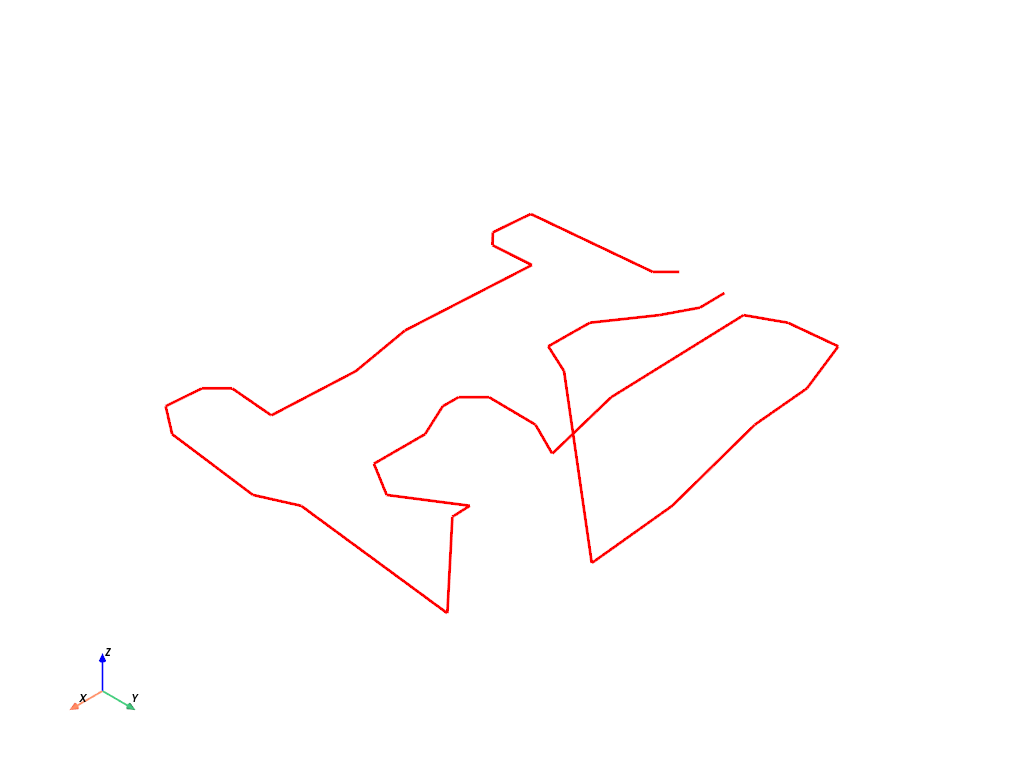

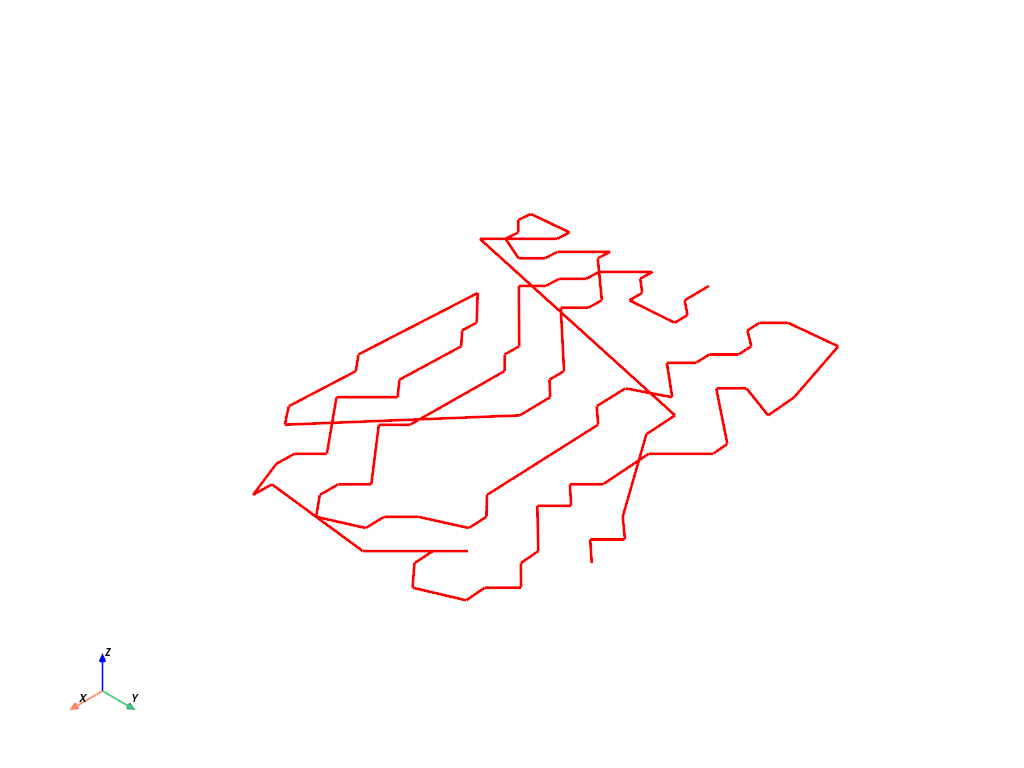

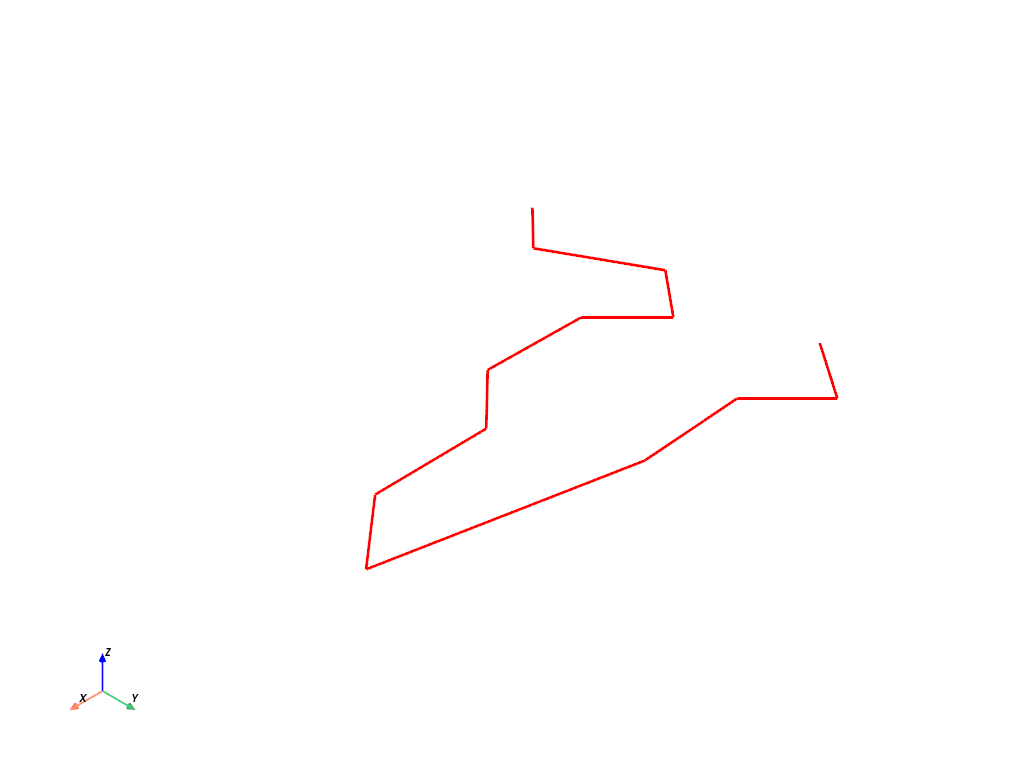

Precomputed paths saved to 'precomputed_paths.json'.


In [13]:
import numpy as np
import pyvista as pv
import cv2
from scipy.spatial import cKDTree
import json

# Parameters
pitch = 0.03     # voxel size
origin = (0.0, 0.0, 0.0)
velocity = 0.05  # m/s
dt = 0.1         # s
downsample_factor = 3  # Reduce resolution by keeping every Nth point

# Assume we have:
# occupancy: 3D numpy array (X, Y, Z) with 1 = occupied (red) and 0 = empty (blue)
X, Y, Z = occupancy.shape
print(Z)

# List to store precomputed paths for each layer
precomputed_paths = []

for k in range(0, Z, 1):  # Iterate through every layer
    slice_k = occupancy[:, :, k]
    layer_z = origin[2] + k * pitch

    # Identify all occupied cells
    occupied_indices = np.argwhere(slice_k == 1)  # returns list of [i, j] with i = y, j = x
    if occupied_indices.size == 0:
        precomputed_paths.append(None)  # No material in this layer
        continue  # No occupied cells in this layer

    # Convert indices to real-world coordinates
    # Swapped i and j interpretation: i is x, j is y
    real_coords = []
    for i, j in occupied_indices:
        x_coord = origin[0] + (i + 0.5) * pitch  # i -> x
        y_coord = origin[1] + (j + 0.5) * pitch  # j -> y
        real_coords.append((x_coord, y_coord, layer_z))
    real_coords = np.array(real_coords)

    # Downsample the points
    real_coords = real_coords[::downsample_factor]

    # Nearest-neighbor path construction
    # 1. Pick start cell: leftmost-bottommost = min by x, then by y
    start_idx = np.lexsort((real_coords[:, 1], real_coords[:, 0]))[0]  # sort by x, then y
    current_point = real_coords[start_idx]
    path = [current_point]

    # Remaining points
    remaining_points = np.delete(real_coords, start_idx, axis=0)

    if len(remaining_points) > 0:
        # Use a KD-Tree for efficient nearest neighbor search
        tree = cKDTree(remaining_points[:, :2])  # only x, y for distance
        current_xy = current_point[:2]

        while len(remaining_points) > 0:
            # Find nearest neighbor
            dist, nn_idx = tree.query(current_xy)
            next_point = remaining_points[nn_idx]

            # Add to path
            path.append(next_point)
            current_xy = next_point[:2]

            # Remove from remaining points
            remaining_points = np.delete(remaining_points, nn_idx, axis=0)
            if len(remaining_points) > 0:
                tree = cKDTree(remaining_points[:, :2])

    path = np.array(path)

    # Save the path for this layer
    precomputed_paths.append(path.tolist())  # Convert to list for JSON serialization

    # Optional: Visualization for debugging
    layer_plotter = pv.Plotter()
    layer_plotter.add_axes()
    if len(path) > 1:
        line = pv.lines_from_points(path)
        layer_plotter.add_mesh(line, color="red", line_width=3, label=f"Layer {k + 1} Path")
    layer_plotter.show()

# Save precomputed paths to a JSON file
with open("precomputed_paths.json", "w") as f:
    json.dump(precomputed_paths, f)

print(f"Precomputed paths saved to 'precomputed_paths.json'.")


In [17]:
import ufl

# Temperature function space (scalar field)
element_temp = basix.ufl.element("Lagrange", domain_mesh.topology.cell_name(), degree=1)
V_T = fem.functionspace(domain_mesh, element_temp)

# Trial and test functions for temperature
T = ufl.TrialFunction(V_T)  # Current temperature
v_T = ufl.TestFunction(V_T)  # Test function

# Initial temperature field (T_prev)
T_prev = fem.Function(V_T)
T_prev.interpolate(lambda x: np.full(x.shape[1], 100.0))  # Initial temperature: 300 K


# Material properties
rho = 7800  # Density (kg/m^3)
cp = 500  # Specific heat capacity (J/kg·K)
k = 45  # Thermal conductivity (W/m·K)


from dolfinx.mesh import locate_entities


# Dirichlet boundary conditions
domain_mesh.topology.create_connectivity(domain_mesh.topology.dim - 1, domain_mesh.topology.dim)

T_bc = fem.Function(V_T)
T_bc.interpolate(lambda x: np.full(x.shape[1], 100.0))  # Fixed boundary temperature

boundary_facets_T = locate_entities(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0.0)
)

# Locate degrees of freedom on these facets
boundary_dofs_T = fem.locate_dofs_topological(V_T, domain_mesh.topology.dim - 1, boundary_facets_T)

# Create Dirichlet BC
bc_T = fem.dirichletbc(T_bc, boundary_dofs_T)



def moving_gaussian_heat_source_with_skipping(x, t, z_layer, path_points, velocity, radius=0.1, intensity=1e6, total_time=10):
    """
    Improved moving Gaussian heat source with point skipping to complete the path in a given timeframe.
    """
    if path_points is None or len(path_points) == 0:
        return np.zeros(x.shape[1])  # No heat source if path is empty

    mask = np.isclose(x[2], z_layer)
    if not np.any(mask):
        return np.zeros(x.shape[1])  # No heat source applied if points are not in this layer

    path_points = np.array(path_points)

    # Calculate the total distance of the path
    distances = np.zeros(len(path_points))
    distances[1:] = np.cumsum(np.linalg.norm(path_points[1:] - path_points[:-1], axis=1))
    total_distance = distances[-1]

    if total_distance == 0:
        center = path_points[0]
    else:
        # Determine the required number of points to fit within the total time
        num_points = len(path_points)
        required_steps = int(total_time / dt)
        effective_step_size = max(1, num_points // required_steps)

        # Sample path points with skipping
        sampled_indices = np.arange(0, num_points, effective_step_size)
        sampled_path = path_points[sampled_indices]

        # Recalculate distances for the sampled path
        distances = np.zeros(len(sampled_path))
        distances[1:] = np.cumsum(np.linalg.norm(sampled_path[1:] - sampled_path[:-1], axis=1))
        total_distance = distances[-1]

        # Determine the position of the heat source along the sampled path
        distance_traveled = (velocity * t) % total_distance
        idx = np.searchsorted(distances, distance_traveled, side="right") - 1

        if idx < len(sampled_path) - 1:
            alpha = (distance_traveled - distances[idx]) / (distances[idx + 1] - distances[idx])
            center = (1 - alpha) * sampled_path[idx] + alpha * sampled_path[idx + 1]
        else:
            center = sampled_path[-1]

    x_eval = x[:, mask]
    r = np.linalg.norm(x_eval.T - center, axis=1)  # Distance from center
    intensity_values = np.zeros(x.shape[1])
    intensity_values[mask] = intensity * np.exp(-r**2 / (2 * radius**2))
    return intensity_values



Layer paths: 6
Simulating layer 1 at z = 0.0


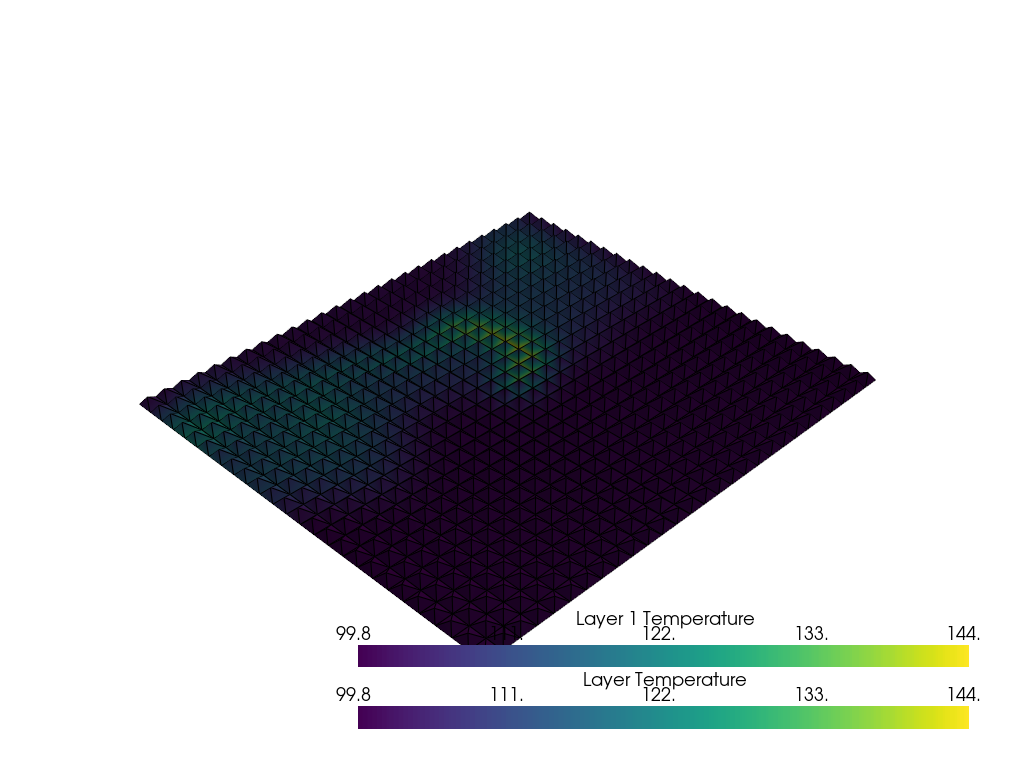

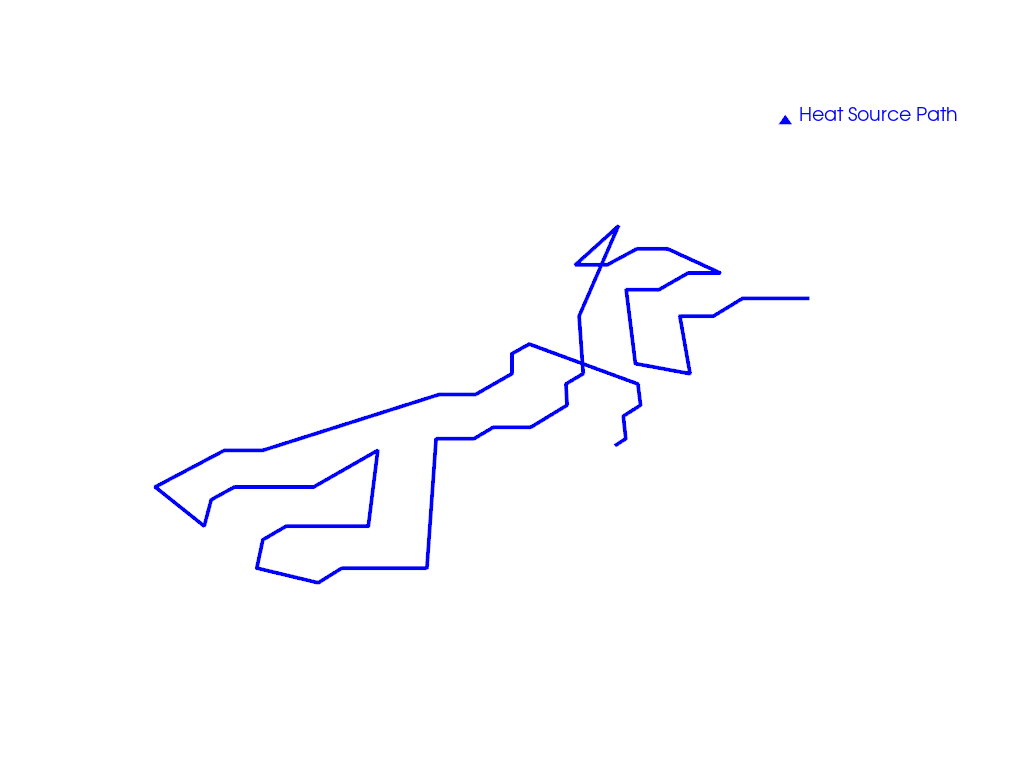

Layer 1 completed.
Simulating layer 2 at z = 0.03


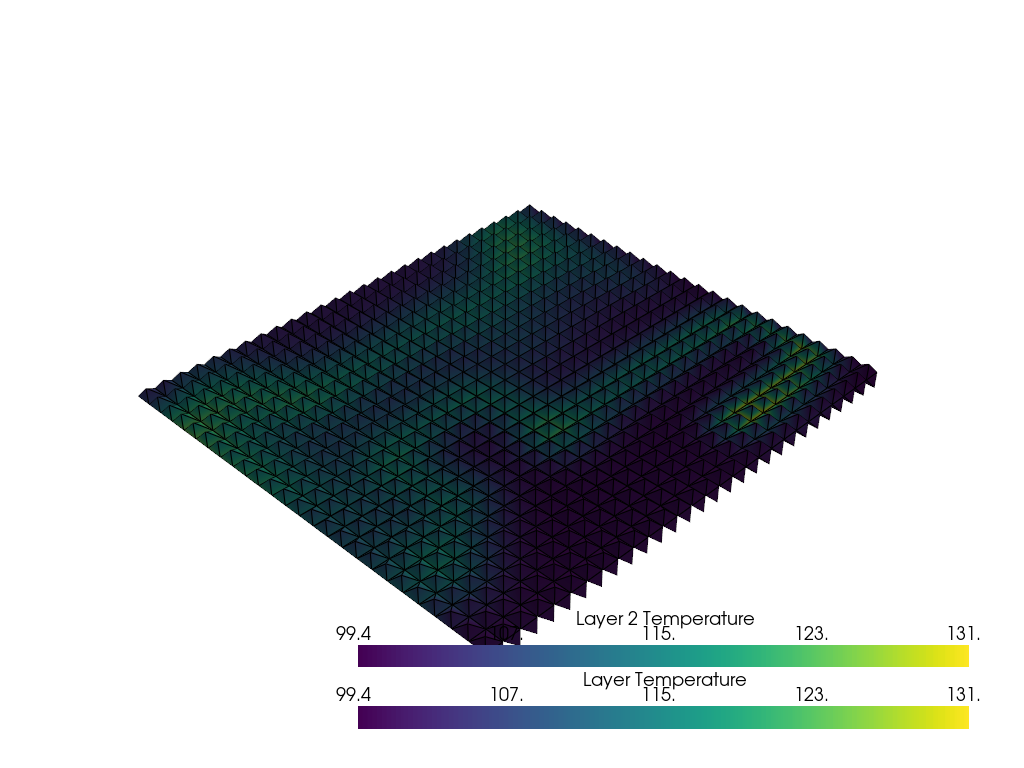

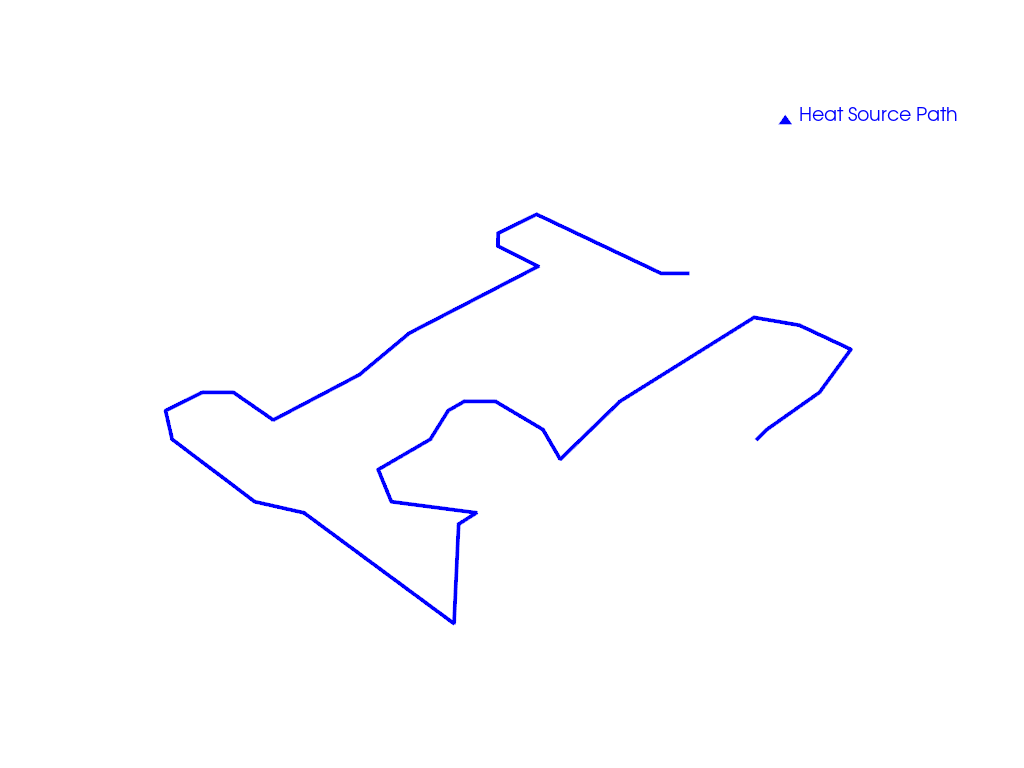

Layer 2 completed.
Simulating layer 3 at z = 0.06


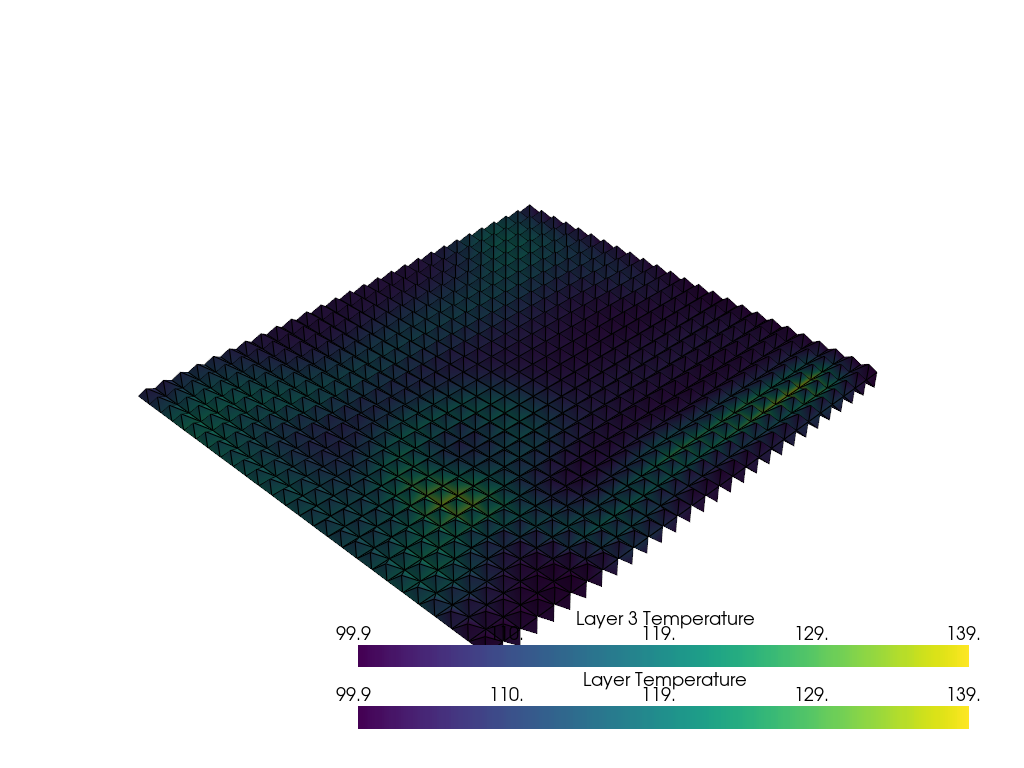

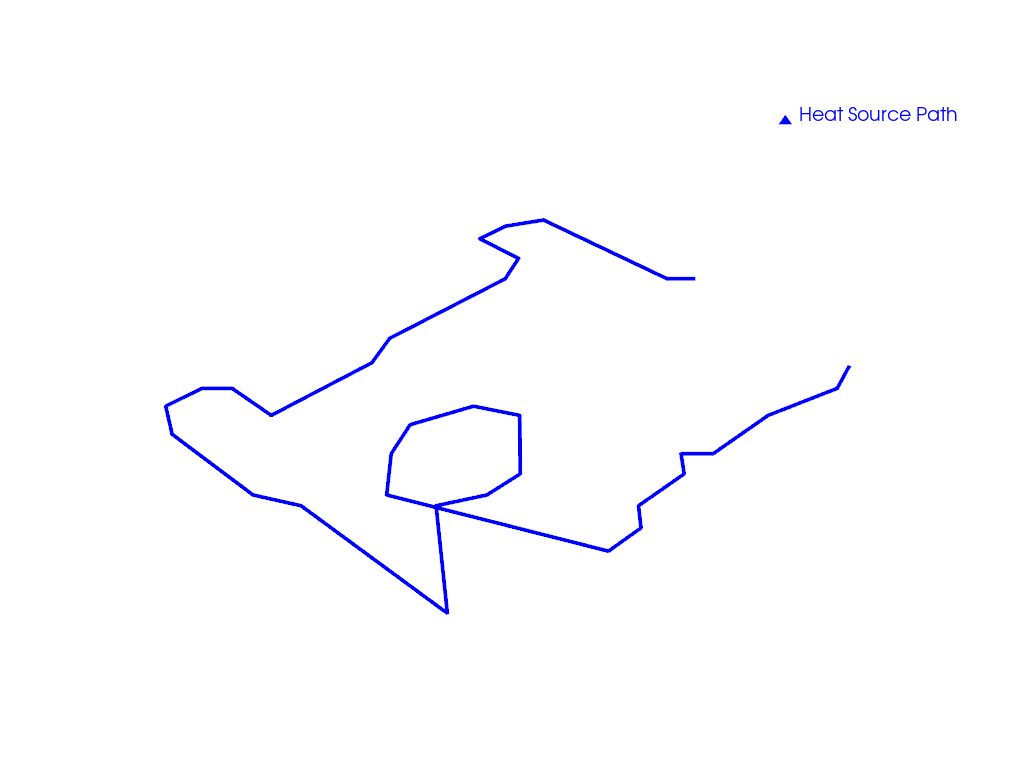

Layer 3 completed.
Simulating layer 4 at z = 0.09


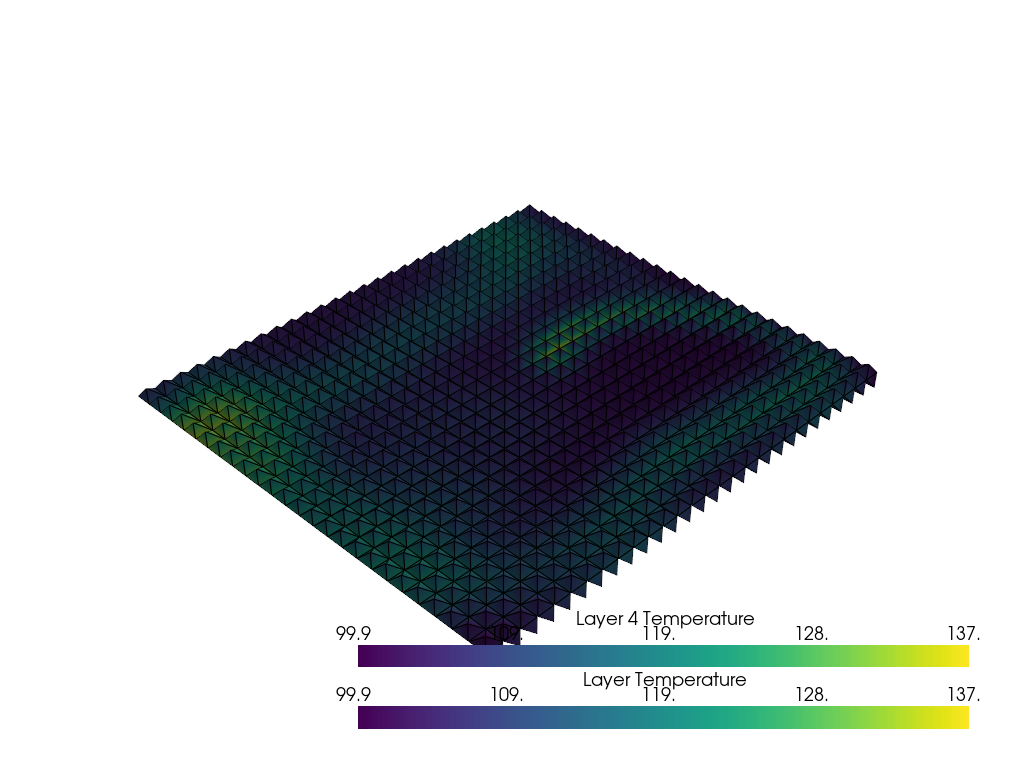

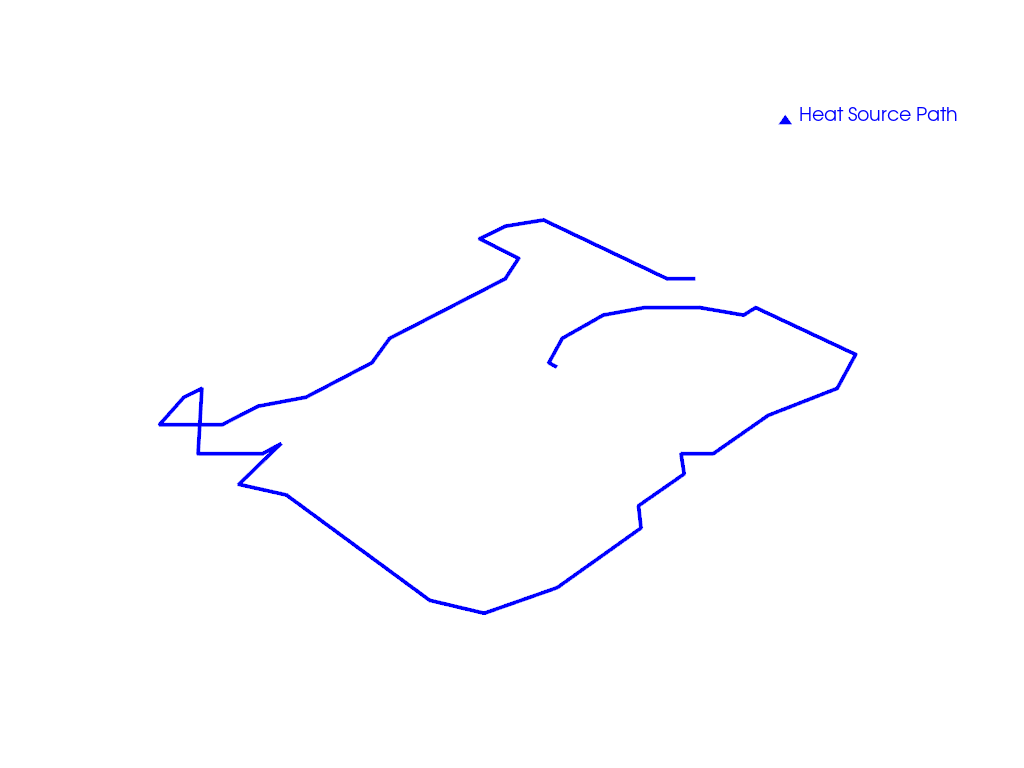

Layer 4 completed.
Simulating layer 5 at z = 0.12


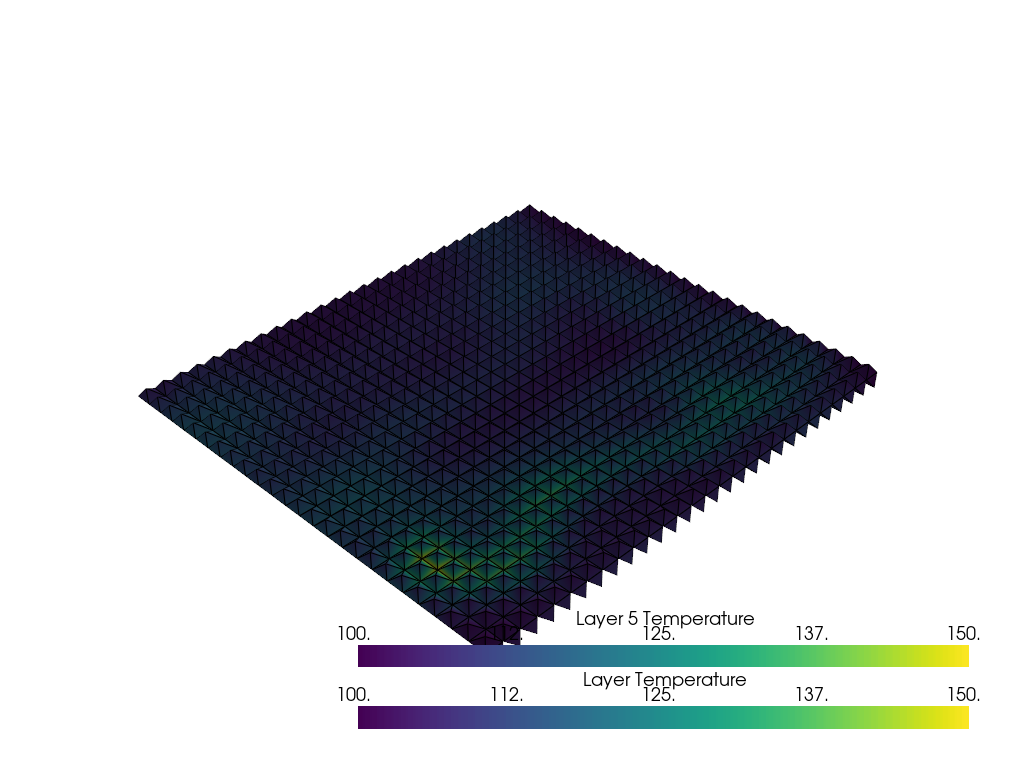

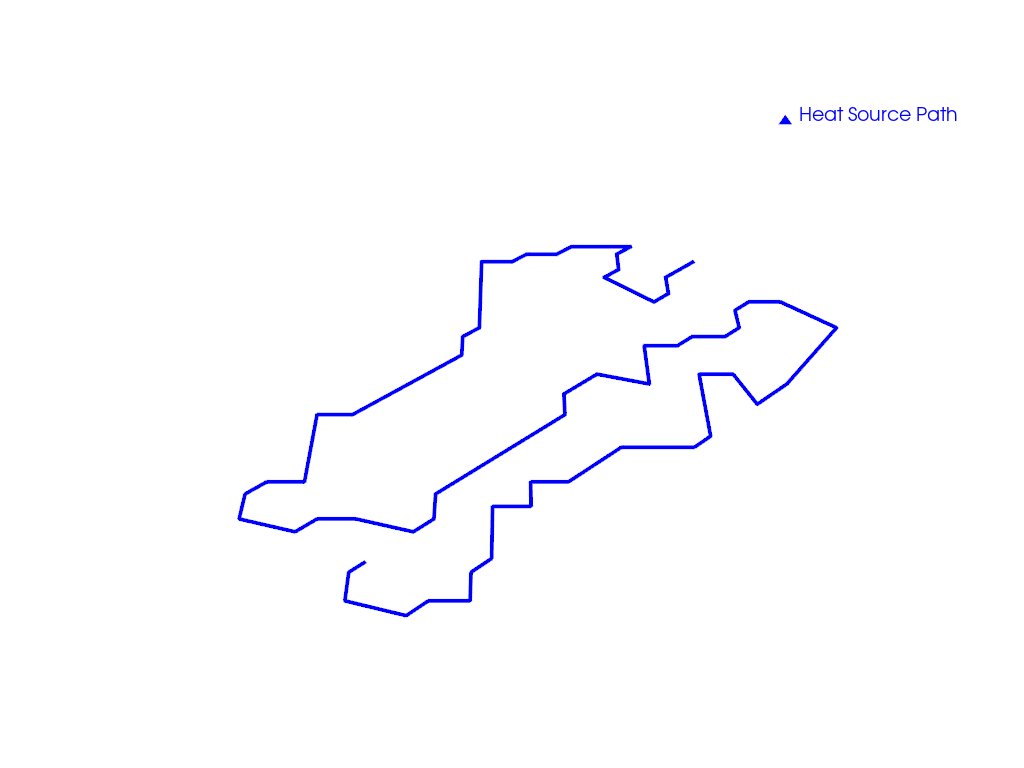

Layer 5 completed.
Simulating layer 6 at z = 0.15


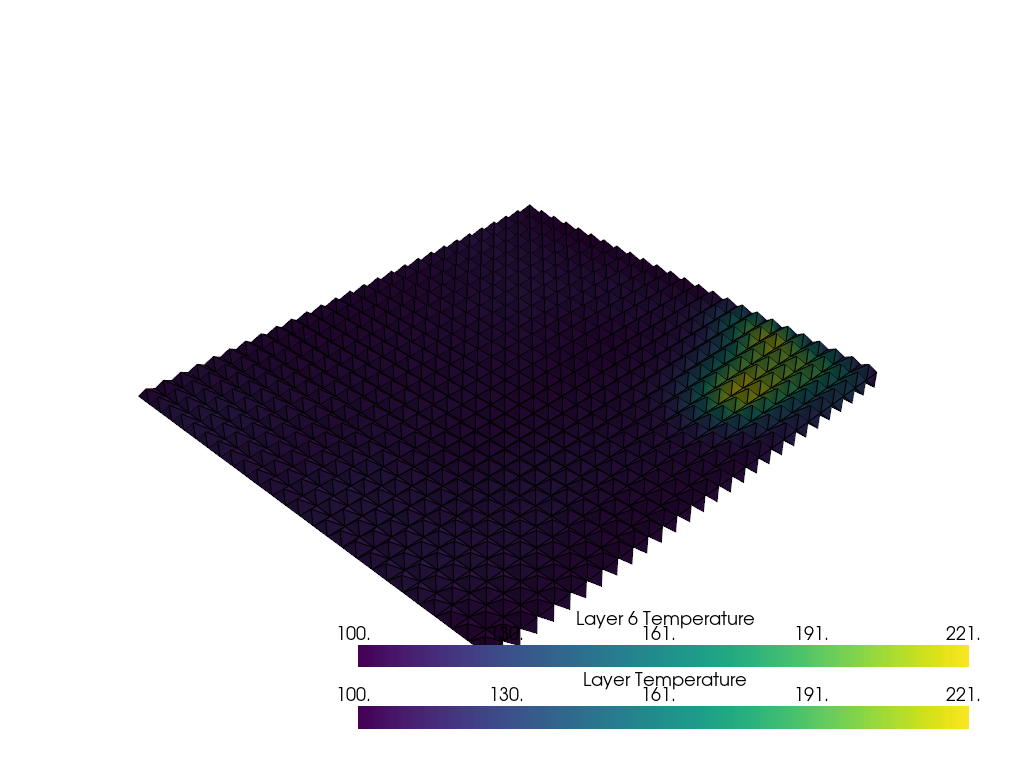

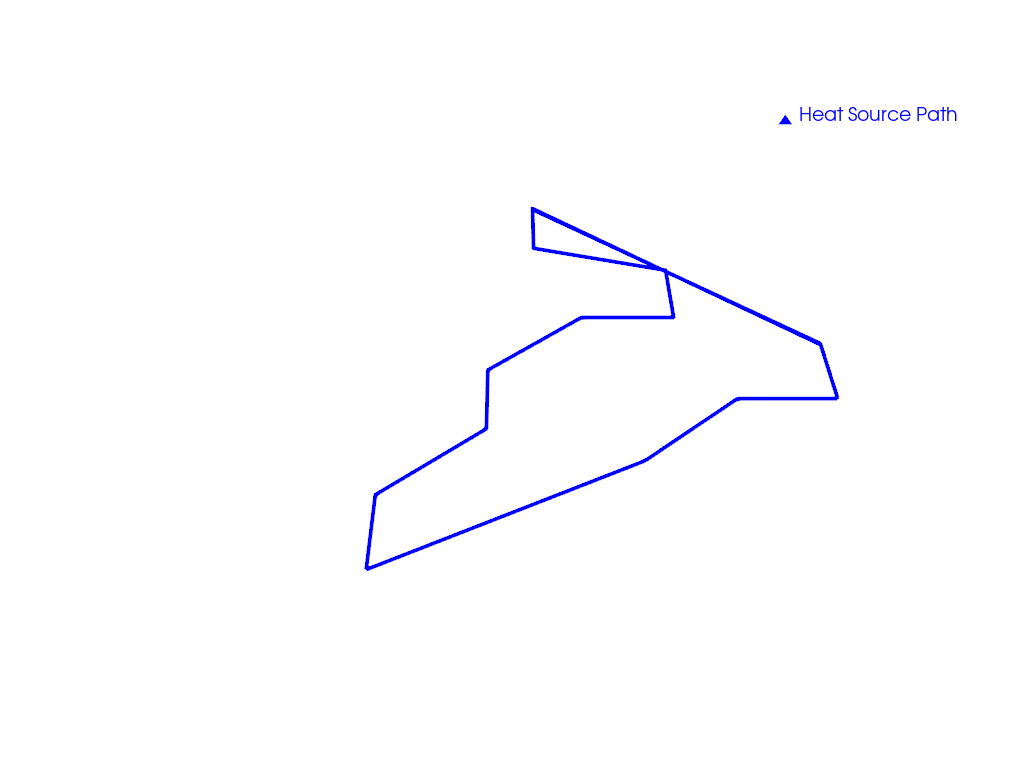

Layer 6 completed.


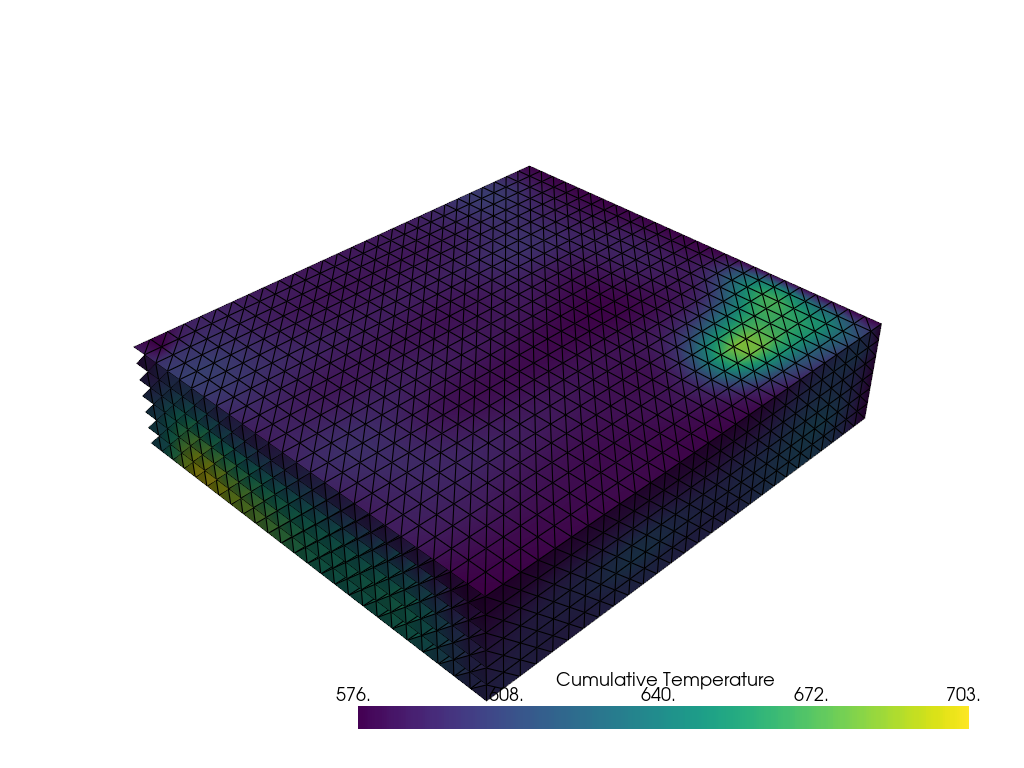

In [15]:
import numpy as np
import pyvista as pv
import ufl
from dolfinx import fem
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import locate_entities
from dolfinx.plot import vtk_mesh
from ufl import grad, dot

# Extract geometry (coordinates) from domain_mesh
topology, cell_types, geometry = vtk_mesh(domain_mesh)

def compute_cell_centroids(mesh):
    """
    Compute the centroids (midpoints) of each cell in the mesh.
    """
    topology = mesh.topology.connectivity(mesh.topology.dim, 0)  # Cells to vertices
    coords = mesh.geometry.x  # Vertex coordinates
    num_cells = mesh.topology.index_map(mesh.topology.dim).size_local  # Total number of cells
    centroids = np.zeros((num_cells, 3))  # Initialize centroids array

    # Access connectivity data as a NumPy array
    connectivity_array = topology.array  # Flattened connectivity data
    offsets = topology.offsets  # Offsets to extract individual cells

    for i in range(num_cells):
        cell = connectivity_array[offsets[i]:offsets[i + 1]]  # Indices of vertices for the current cell
        cell_vertices = coords[cell]
        centroids[i] = np.mean(cell_vertices, axis=0)  # Average of vertex coordinates
    return centroids

# Compute centroids for the domain mesh
cell_centroids = compute_cell_centroids(domain_mesh)

# Initialize an accumulated temperature function
T_accum = fem.Function(V_T)
T_accum.x.array[:] = T_prev.x.array[:]  # Start with the initial temperature field

# Parameters
velocity_x = 0.05  # m/s
dt = 0.05  # Time step size
radius = 0.03  # Laser radius
intensity = 1e8  # Heat source intensity
t_layer = 70  # Time per layer (s)
num_steps_per_layer = int(t_layer / dt)
pitch = 0.03  # Layer pitch
layers = range(0, int(geometry[:, 2].max() / pitch), 1)  # Layers to simulate

melt_temp = 200
cooling_factor = 0.95  # Cooling factor between layers (optional)

voxel_states = np.zeros(len(cell_centroids), dtype=int)

# Precomputed paths for each layer
layer_paths = precomputed_paths  # Assume precomputed paths are available as a list of arrays, one per layer.
print(f"Layer paths: {len(layer_paths)}")

path_num = 0
for layer in layers:
    z_layer = layer * pitch  # Current layer height
    print(f"Simulating layer {layer + 1} at z = {z_layer}")

    def active_layer_subdomain(centroids):
        return np.logical_and(
            centroids[:, 2] >= z_layer - (pitch / 2),  # Lower bound
            centroids[:, 2] < z_layer + (pitch / 2)   # Upper bound
        )

    active_cells_mask = active_layer_subdomain(cell_centroids)
    active_cells = np.where(active_cells_mask)[0]  # Indices of active cells

    if len(active_cells) == 0:
        print(f"Skipping layer {layer + 1}: no active cells found in domain mesh.")
        continue

    dx_layer = ufl.Measure("dx", domain=domain_mesh, subdomain_data=active_cells)
    path_points = layer_paths[path_num]
    actual_heat_source_positions = []  # Store heat source positions for visualization

    for step in range(num_steps_per_layer):
        t = step * dt  # Time within the layer

        Q = fem.Function(V_T)
        Q.interpolate(lambda x: moving_gaussian_heat_source_with_skipping(
            x, t, z_layer, path_points, velocity_x, radius, intensity, total_time=t_layer
        ))

        # Track the current position of the heat source
        path_points = np.array(path_points)
        distances = np.zeros(len(path_points))
        distances[1:] = np.cumsum(np.linalg.norm(path_points[1:] - path_points[:-1], axis=1))
        total_distance = distances[-1]

        if total_distance > 0:
            distance_traveled = (velocity_x * t) % total_distance
            idx = np.searchsorted(distances, distance_traveled, side="right") - 1
            if idx < len(path_points) - 1:
                alpha = (distance_traveled - distances[idx]) / (distances[idx + 1] - distances[idx])
                current_position = (1 - alpha) * path_points[idx] + alpha * path_points[idx + 1]
            else:
                current_position = path_points[-1]

            actual_heat_source_positions.append(current_position)

        a_T = (rho * cp / dt) * T * v_T * dx_layer + k * dot(grad(T), grad(v_T)) * dx_layer
        L_T = (rho * cp / dt) * T_prev * v_T * dx_layer + Q * v_T * dx_layer

        temp_problem = LinearProblem(a_T, L_T, bcs=[bc_T])
        T_sol = temp_problem.solve()
        T_prev.x.array[:] = T_sol.x.array[:]

    path_num += 1

    # Visualization for the current layer (temperature field)
    grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    grid.point_data["Layer Temperature"] = T_sol.x.array  # Use temperature for the current layer

    layer_mask = np.logical_and(
        cell_centroids[:, 2] >= z_layer - (pitch / 2),
        cell_centroids[:, 2] < z_layer + (pitch / 2)
    )

    layer_indices = np.where(layer_mask)[0]
    layer_grid = grid.extract_cells(layer_indices)

    plotter_temp = pv.Plotter()
    plotter_temp.add_mesh(layer_grid, scalars="Layer Temperature", cmap="viridis", show_edges=True)
    plotter_temp.add_scalar_bar(title=f"Layer {layer + 1} Temperature")
    plotter_temp.show()

    # Visualization for the actual heat source path
    if len(actual_heat_source_positions) > 1:
        actual_positions = np.array(actual_heat_source_positions)
        actual_path = pv.lines_from_points(actual_positions)

        plotter_path = pv.Plotter()
        plotter_path.add_mesh(actual_path, color="blue", line_width=4, label="Heat Source Path")
        plotter_path.add_legend()
        plotter_path.show()
    else:
        print(f"No positions recorded for the moving Gaussian heat source.")

    T_accum.x.array[:] += T_sol.x.array[:]  # Accumulate temperatures
    T_accum.x.array[:] *= cooling_factor  # Cooling effect

    print(f"Layer {layer + 1} completed.")

# Visualization of the cumulative temperature field
grid = pv.UnstructuredGrid(topology, cell_types, geometry)
grid.point_data["Cumulative Temperature"] = T_accum.x.array
plotter = pv.Plotter()
plotter.add_mesh(grid, scalars="Cumulative Temperature", cmap="viridis", show_edges=True)
plotter.add_scalar_bar(title="Cumulative Temperature")
plotter.show()


Layer paths: 6
Simulating layer 1 at z = 0.0
Total distance for layer 1: 8.48 m
Total time for layer 1: 169.66 s
Number of time steps: 3394


NameError: name 'moving_heat_source' is not defined